In [2]:
# Import of the library
import scipy.io
import pandas as pd

# From Abdel github 
import numpy as np 
from scipy.signal import savgol_filter
from scipy.signal import iirdesign
from scipy.signal import filtfilt
fs = 2500 # EEG sampling frequency
window_length = 2*fs
epoch_length = int(window_length/fs)

In [3]:
# Loading of the file
mat_HPC = scipy.io.loadmat('HPC_100_CH46.continuous.mat')
mat_PFC = scipy.io.loadmat('PFC_100_CH11.continuous.mat')


In [4]:
# Conversion of the dict to a dataframe 
df_HPC = pd.DataFrame.from_dict(mat_HPC['HPC'])
df_PFC = pd.DataFrame.from_dict(mat_PFC['PFC'])
df_HPC = df_HPC.rename(columns={0: 'HPC'})
df_PFC = df_PFC.rename(columns={0: 'PFC'})

In [5]:
df_HPC.head()

,HPC
0,-7.877379
1,-50.056636
2,-107.115513
3,-61.166557
4,-5.591746


In [6]:
df = pd.concat([df_HPC, df_PFC], axis=1)
df.head()

,HPC,PFC
0,-7.877379,9.024873
1,-50.056636,-51.521744
2,-107.115513,-127.409987
3,-61.166557,-71.890093
4,-5.591746,9.389867


<Axes: >

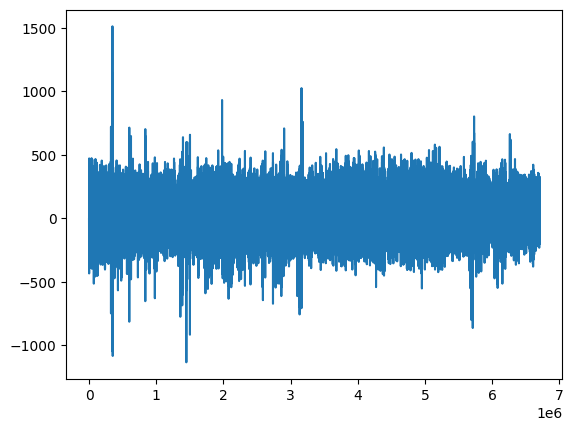

In [14]:
df['HPC'].plot()

In [8]:
#df['PFC'].plot()

In [9]:
def compute_emg_buzsakiMethod(x, y, sig1, sig2, smoothWindow, matfilename):
    """
    The input of this function:
    x --> is the target sampling of the EMG
    y --> is the sampling frequency of the data
    sig1 --> the signal of the first channel
    sig2 --> the signal of the second channel
    smooth --> the smoothing window for the EMG data
    matfilename --> the name of the saved matrix
    """
    binScootS = 1 / x
    binScootSamps = round(y * binScootS)

    # 2. Filter the signal in the high frequency range
    # Filter first in high frequency band to remove low-freq physiologically
    # correlated LFPs (e.g., theta, delta, SPWs, etc.)
    maxfreqband = int(min(625, y / 2))
    xcorr_freqband = [275, 300, maxfreqband - 25, maxfreqband-0.0000001]  # Hz
    filteredSig1 = filtsig_in(sig1, y, xcorr_freqband)[0]
    filteredSig2 = filtsig_in(sig2, y, xcorr_freqband)[0]

    # 3. The relevant parameters important for further correlation analysis
    xcorr_window_samps = round(binScootS * y)
    xcorr_window_inds = np.arange(-xcorr_window_samps, xcorr_window_samps + 1)
    timestamps = np.arange(xcorr_window_inds[-1], sig1.shape[0] - xcorr_window_inds[-1], binScootSamps)
    numbins = len(timestamps)
    EMGCorr = np.zeros(numbins)
    c1, c2 = [], []
    binind, binindstart = -1, 0

    # Loop through different windows
    for i in range(numbins):
        binind += 1
        s1 = []
        s2 = []
        for k in (timestamps[i] + xcorr_window_inds):
          s1.append(filteredSig1[k])
          s2.append(filteredSig2[k])
        c1.append(s1)
        c2.append(s2)
        binindend = binind
        tmp = np.corrcoef(c1, c2)[0, 1]
        EMGCorr[binindstart:(binindend+1)] += tmp
        c1, c2 = [], []
        binindstart = binind + 1

    EMGCorr = EMGCorr/(2 * (2 - 1) / 2)
    EMGNorm = bz_NormToRange(EMGCorr, [0, 1])

    # Making the final structure of the EMG
    EMGFromLFP = {
        'timestamps': timestamps / y,
        'data': EMGCorr,
        'Norm': EMGNorm,
        'channels': 'HPC and PFC',
        'detectorName': 'bz_EMGFromLFP',
        'samplingFrequency': x
    }

    # Smoothing the EMG data
    dtEMG = 1 / EMGFromLFP['samplingFrequency']
    EMGFromLFP['smoothed'] = savgol_filter(EMGFromLFP['data'], window_length=smoothWindow, polyorder=4)

    # Saving the data matrix
    np.save(matfilename, EMGFromLFP)
    return EMGFromLFP

def filtsig_in(sig, Fs, filtband_or_Filt):
    """
    [filt_sig, Filt] = filtsig(sig, dt_ms, filtband_or_Filt)
    Created by: Erik Schomburg, 2011
    """
    if isinstance(filtband_or_Filt, (list, np.ndarray)):
        b, a = iirdesign(wp=[filtband_or_Filt[1], filtband_or_Filt[2]], ws=[filtband_or_Filt[0], filtband_or_Filt[3]], gpass=1, gstop=60, fs=Fs)
        Filt = (b, a)
    else:
        Filt = filtband_or_Filt

    if sig is not None:
        if isinstance(sig, list):
            filt_sig = [filtfilt(Filt[0], Filt[1], s) for s in sig]
        elif sig.ndim > 1:
            filt_sig = np.array([filtfilt(Filt[0], Filt[1], s) for s in sig.T]).T
        else:
            filt_sig = filtfilt(Filt[0], Filt[1], sig)
    else:
        filt_sig = []

    return filt_sig, Filt

def bz_NormToRange(data, newrange):
    """
    Normalize data to a new range
    """
    a, b = newrange
    x = data.copy()
    xmin, xmax = x.min(), x.max()
    return a + (x - xmin) * (b - a) / (xmax - xmin)
     

In [10]:
def getNewFeatures(raw_hpc, raw_pfc):

  # Getting EMG
  emg_sampling = 5
  smoothWindow = fs
  EMGFromLFP = compute_emg_buzsakiMethod(emg_sampling,fs,raw_pfc,raw_hpc,smoothWindow,'emglikesignal')
  EMG = EMGFromLFP['data']
  emg_mat_norm = EMGFromLFP['Norm']
  emg_mat_smoothed = EMGFromLFP['smoothed']
  if len(EMG) % 2 == 1:
    EMG = np.append(EMG, EMG[-1])
  EMG =EMG[:len(EMG) // (epoch_length*emg_sampling) * (epoch_length*emg_sampling)]
  EMG = EMG.reshape(-1, (epoch_length*emg_sampling))
  EMG = EMG.sum(axis=1)
  return EMGFromLFP

In [11]:
EMGFromLPF = getNewFeatures (df['HPC'],df['PFC'])

In [12]:
EMGFromLPF

{'timestamps': array([2.0000e-01, 4.0000e-01, 6.0000e-01, ..., 2.6844e+03, 2.6846e+03,
        2.6848e+03]),
 'data': array([0.67008452, 0.73658529, 0.78730533, ..., 0.86134975, 0.85225682,
        0.86328853]),
 'Norm': array([0.748518  , 0.80341278, 0.84528096, ..., 0.90640285, 0.89889685,
        0.90800327]),
 'channels': 'HPC and PFC',
 'detectorName': 'bz_EMGFromLFP',
 'samplingFrequency': 5,
 'smoothed': array([0.79435783, 0.79412351, 0.79388997, ..., 0.60517372, 0.60282959,
        0.60047472])}

In [13]:
from sklearn.cluster import DBSCAN

# DBSCAN
db = DBSCAN(eps=0.5, min_samples=2).fit(df)
labels_db = db.labels_
